Result computation and analysis of MNIST toy experiment. Goal is to see on a toy example how layer rotation affects the features learned by a network.


Experiment info:

1 layer MLP (784 hidden) + batchnorm (batchnorm was used to enable larger layer rotations)  
reduced MNIST dataset (1000 samples per class) (to increase overparametrization)  
Layca as optimization algorithm  
different initial learning rates

In [33]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
%autoreload
import sys
sys.path.insert(0, "../")

import warnings
import os
import time

import math as m
import numpy as np
np.random.seed(1)

import matplotlib
import matplotlib.pyplot as plt
import pickle

from keras.layers import Input, Dense, BatchNormalization, Activation
from keras.models import Model

# Force reload of layca_optimizers to pick up fixes
import importlib
if 'layca_optimizers' in sys.modules:
    importlib.reload(sys.modules['layca_optimizers'])
from layca_optimizers import SGD

from keras.callbacks import LearningRateScheduler

from experiment_utils import plot_history, history_todict
from layer_rotation_utils import LayerRotationCurves, plot_layer_rotation_curves
from experiment_utils import lr_schedule

from feature_visualization import visualize_1stlayer_weights
from utils import load_reduced_mnist_data

In [35]:
# utilities for storing the results in pickle files
result_file = 'results.p'
def load_results():
    if not os.path.isfile(result_file):
        return {}
    else:
        with open(result_file,'rb') as f:
            return pickle.load(f)

def dump_results(results):
    with open(result_file,'wb') as f:
        pickle.dump(dict(results),f)

def update_results(path, new_data):
    results = load_results()
    position = results
    for p in path:
        position = position[p]
    # new_data is a dictionary with the new (key,value) pairs
    position.update(new_data)
    dump_results(results)
    
# if results should be saved in the file or not
save_results = True
if not save_results:
    results = {}

In [36]:
# smaller dataset to get overparametrized model
x_train, y_train, x_test, y_test = load_reduced_mnist_data(samples_per_class = 1000)

In [37]:
def get_model():
    inp = Input((784,))
    x = Dense(784, activation = 'linear', name = 'dense0')(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dense(10, activation = 'softmax', name = 'densef')(x)
    return Model(inp,x)

In [38]:
# configuration of the different learning rate schedules 
# (a division of the learning rate by 5 is used to escape plateaus in the loss curve)
training_configs = {3**-2: (100, LearningRateScheduler(lr_schedule(3**-2,1./5.,[90]))),
                    3**-2.5: (100, LearningRateScheduler(lr_schedule(3**-2.5,1./5.,[95]))),
                    3**-3: (100, LearningRateScheduler(lr_schedule(3**-3,1./5.,[95]))),
                    3**-4: (100, LearningRateScheduler(lr_schedule(3**-4,1.,[np.inf]))),
                    3**-5: (120, LearningRateScheduler(lr_schedule(3**-5,1.,[np.inf]))),
                    3**-6: (300, LearningRateScheduler(lr_schedule(3**-6,1.,[np.inf]))),
                    3**-7: (1000, LearningRateScheduler(lr_schedule(3**-7,1.,[np.inf])))}

lrs = [3**-2,3**-2.5,3**-3,3**-4]
for lr in lrs:
    model = get_model()

    weights_location = 'saved_weights/mnist_initial_weights.weights.h5'
    if not os.path.isfile(weights_location):
        model.save_weights(weights_location)
    else:
        model.load_weights(weights_location)

    epochs = training_configs[lr][0]
    lr_sched = training_configs[lr][1]

    ladc = LayerRotationCurves(batch_frequency = np.inf)

    model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(lr,layca = True),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        batch_size=2048,
                        epochs=epochs,
                        verbose=0,
                        validation_data = (x_test,y_test),
                        callbacks = [ladc, lr_sched])


    if save_results:
        update_results([],{lr:{'history':history_todict(history),'ladc':ladc.memory}})
    else:
        results.update({lr:{'history':history_todict(history),'ladc':ladc.memory}})

    if save_results:
        model.save_weights('saved_weights/'+str(round(lr,6))[2:]+'.weights.h5')
        
def get_aspect(ax=None):  # used to compute rotation of text here under
    if ax is None:
        ax = plt.gca()
    fig = ax.figure

    ll, ur = ax.get_position() * fig.get_size_inches()
    width, height = ur - ll
    axes_ratio = height / width
    aspect = axes_ratio / ax.get_data_ratio()

    return aspect

AttributeError: 'XAxis' object has no attribute 'get_converter'

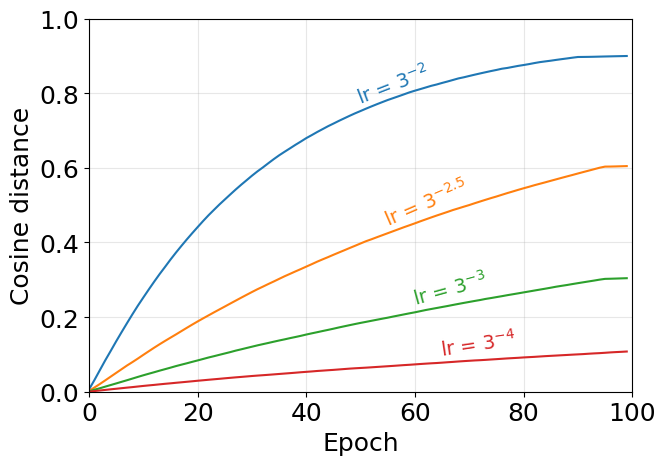

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import math as m

# Config
plt.rcParams.update({'font.size': 18})
LRS = [3**-2, 3**-2.5, 3**-3, 3**-4]
LRS_LABELS = [r'lr = $3^{-2}$', r'lr = $3^{-2.5}$', r'lr = $3^{-3}$', r'lr = $3^{-4}$']

# Load stored results
results = load_results()

# Plot
plt.figure(figsize=(7,5))
plt.ylim(0, 1)
plt.xlim(0, 100)

for i, (lr, label) in enumerate(zip(LRS, LRS_LABELS)):
    ladc = np.array(results[lr]['ladc'])[:, 0]
    plt.plot(ladc, label=label)

    # Annotate slope-aligned label at a chosen x position
    x = 50 + 5*i
    dx = 30
    slope = (ladc[x+dx] - ladc[x]) / dx * get_aspect()
    angle = m.degrees(m.atan(slope))

    plt.annotate(
        label,
        xy=(x, ladc[x]),
        xycoords='data',
        color=f'C{i}', size=14,
        rotation=angle+5, rotation_mode='anchor',
        xytext=(0, 5), textcoords='offset points'
    )

plt.xlabel('Epoch')
plt.ylabel('Cosine distance')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('figures/mnist_layer_rotations.png', dpi=200, bbox_inches="tight")
plt.show()


In [40]:
lrs = [3**-2,3**-2.5,3**-3,3**-4]

results = load_results()
test_performances = []
train_performances = []
for lr in lrs:
    # Handle both old and new metric names for compatibility
    if 'val_acc' in results[lr]['history']['history']:
        test_performances.append(results[lr]['history']['history']['val_acc'][-1])
        train_performances.append(results[lr]['history']['history']['acc'][-1])
    else:
        test_performances.append(results[lr]['history']['history']['val_accuracy'][-1])
        train_performances.append(results[lr]['history']['history']['accuracy'][-1])
print(test_performances)
print()
print(train_performances)

[0.9666000008583069, 0.9652000069618225, 0.964900016784668, 0.9564999938011169]

[0.9998999834060669, 1.0, 1.0, 1.0]


AttributeError: 'XAxis' object has no attribute 'get_converter'

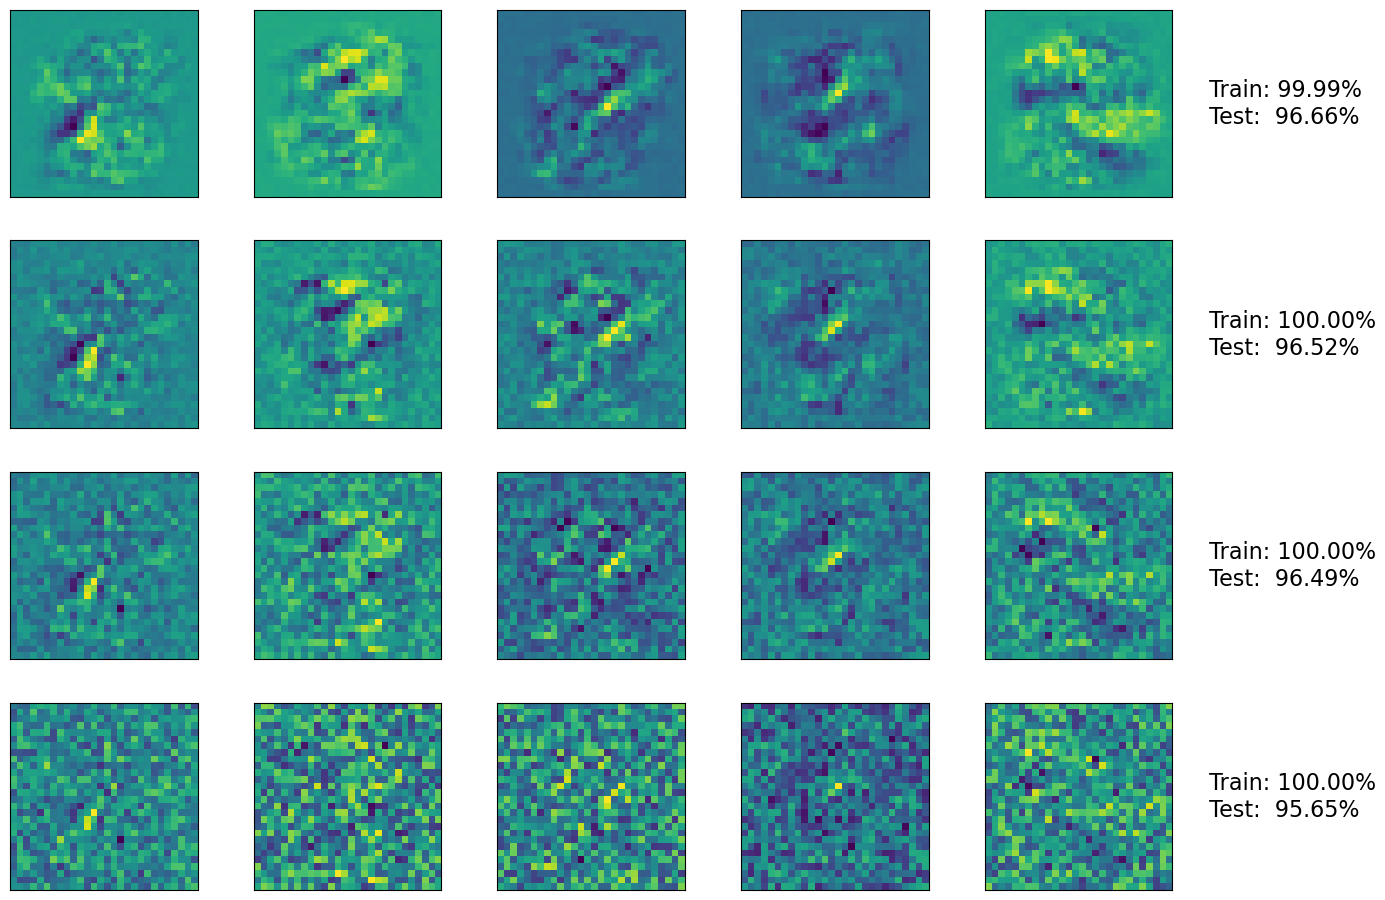

AttributeError: 'XAxis' object has no attribute 'get_converter'

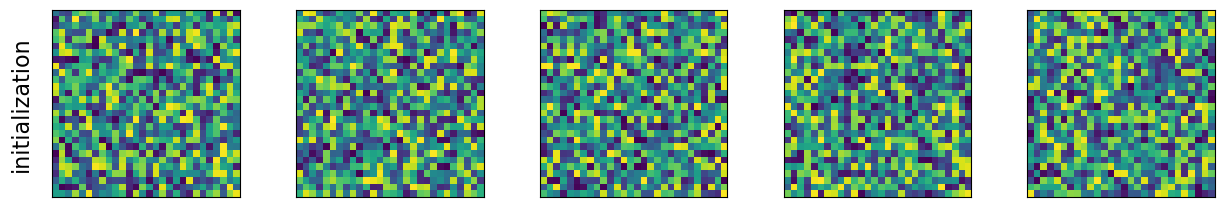

In [41]:
import numpy as np
import matplotlib.pyplot as plt

LRS = [3**-2, 3**-2.5, 3**-3, 3**-4]
NB_NEURONS = 5
NEURON_IDX = range(5, 10)
CELL = 3  # size per subplot cell

def weight_path(lr: float) -> str:
    return f"saved_weights/{str(round(lr, 6))[2:]}.weights.h5"

def get_final_metrics(hist: dict) -> tuple[float, float]:
    h = hist['history']
    train = h.get('accuracy', h.get('acc'))[-1]
    val   = h.get('val_accuracy', h.get('val_acc'))[-1]
    return train, val

def plot_row(model, lr, axes_row, train_acc, val_acc):
    model.load_weights(weight_path(lr))
    w0 = model.get_weights()[0]  # first layer
    visualize_1stlayer_weights(
        w0,
        nb_neurons=NB_NEURONS,
        neuron_indices=NEURON_IDX,
        neurons_per_line=NB_NEURONS,
        axes=axes_row
    )
    axes_row[-1].annotate(
        f" Train: {train_acc*100:.2f}%\n Test:  {val_acc*100:.2f}%",
        xy=(0., 0.5),
        xycoords=axes_row[-1].yaxis.label,
        textcoords='offset points',
        xytext=(160, 0),  # push text into the empty right margin
        size=16, ha='left', va='center'
    )

# ---- Plot learned filters per LR ----
results = load_results()
model = get_model()

fig, axes = plt.subplots(len(LRS), NB_NEURONS, figsize=(NB_NEURONS*CELL, len(LRS)*CELL))

for i, lr in enumerate(LRS):
    tr, va = get_final_metrics(results[lr]['history'])
    plot_row(model, lr, axes[i], tr, va)

plt.subplots_adjust(wspace=0.3, hspace=0.0)
plt.savefig('figures/mnist_features_visualization.png', dpi=200, bbox_inches="tight")
plt.show()

# ---- Plot initialization filters ----
fig, axes = plt.subplots(1, NB_NEURONS, figsize=(NB_NEURONS*CELL, 1*CELL))
model.load_weights('saved_weights/mnist_initial_weights.weights.h5')
w0_init = model.get_weights()[0]

visualize_1stlayer_weights(
    w0_init,
    nb_neurons=NB_NEURONS,
    neuron_indices=NEURON_IDX,
    neurons_per_line=NB_NEURONS,
    axes=axes
)

axes[0].annotate(
    'initialization',
    xy=(0, 0.5),
    xycoords=axes[0].yaxis.label,
    textcoords='offset points',
    xytext=(-10, 0),
    size=16, ha='right', va='center', rotation=90
)

plt.subplots_adjust(wspace=0.3)
plt.savefig('figures/mnist_initialization_visualization.png', dpi=200, bbox_inches="tight")
plt.show()
